# Transfer learning

Das Ziel des Transferlearning ist es, ein bereits trainiertes Modell auf eine andere Aufgabe zu trainieren. Die Idee dahinter ist den Teil des Netzwerks, der für die Extraktion von Merkmalen zuständig ist, zu "recyceln". Da dies in der Regel der teuerste Teil des Trainings ist, spart man sich dadurch eine Menge an Zeit. Das bedeutet, dass dieser Teil nicht neu trainiert werden muss, sondern die bereits trainierte Featurextraktion genauso gut für eine ähnliche Aufgabe verwendet werden kann. Aus diesem Grund sollte man ein bereits trainiertes Netzwerk nutzen, welches für eine ähnliche Aufgabe trainiert wurde. Lediglich die Klassifikationsschicht wird neu trainiert. Ziel dieses Notebooks ist es, ein Verständnis zu bekommen, was beim Transferlearning passiert.

Schauen Sie sich folgendes Notebook an und versuchen Sie den groben Ablauf zu verstehen.
Sie werden die meisten Befehle die Sie benötigen darin finden.
https://www.tensorflow.org/tutorials/images/transfer_learning

Für diese Aufgabe wollen wir das in der letzten Aufgabe trainierte Convolutional Neural Network, welches auf dem Mnist Datensatz trainiert wurde, auf eine andere Aufgabe trainieren. Die Aufgabe des Netzwerks soll es sein, Hexadezimalzahlen zu erkennen.
Hierzu verwenden wir den $\textit{emnist}$ Datensatz. Dieser beinhaltet zusätzlich das Alphabet (große und kleine Buchstaben). Näheres dazu unter https://pypi.org/project/emnist/ 

Gehen Sie dazu wie folgt vor:

- Laden Sie ihr Modell aus der vorherigen Aufgabe mit tf.keras.models.load_model("Name des Modells") Falls Sie ihr Modell nicht gespeichert hatten, können Sie dies mit model.save("Name des Modells"), nachdem Sie erneut trainiert haben, tun.
- Bereiten Sie den emnist-Datensatz wie in der vorherigen Aufgabe vor und sortieren Sie alle Kleinbuchstaben sowie alle Buchstaben, die nicht der Hexadezimalschreibweise angehören, aus!     
- Laden Sie das zuvor gespeicherte Modell und entfernen Sie die letzte Schicht ( model.pop() )
- Frieren Sie das Modell ein, d.h. Sie setzen die Layer auf nicht trainierbar
- Fügen Sie eine neue Schicht hinzu, sodass die verschiedenen Klassen (0-F) klassifiziert werden können (Wir beschränken uns hier auf die groß geschriebenen Buchstaben)
- Trainieren Sie das Netzwerk mit den transformierten Labels
- Plotten Sie wieder die Trainingskurven und erstellen sie eine confusion Matrix

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix 
from extra_keras_datasets import emnist

2024-06-21 11:23:51.928582: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-21 11:23:51.928800: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 11:23:51.970671: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 11:23:52.092217: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 11:23:52.945686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
# Vorbereiten von Nist

(input_train, target_train), (input_test, target_test) = emnist.load_data(type='balanced')

# Sortieren Sie alle Ziffern aus, die unerwünscht sind!
# Hinweis: np.where ist hierfür recht Hilfreich
mask = list(range(0, 16))
hex_filter_train = np.isin(target_train, mask)
hex_filter_test = np.isin(target_test, mask)
X_train, Y_train = input_train[hex_filter_train], target_train[hex_filter_train]
X_test, Y_test = input_test[hex_filter_test], target_test[hex_filter_test]

INFO:root:Loading dataset = emnist


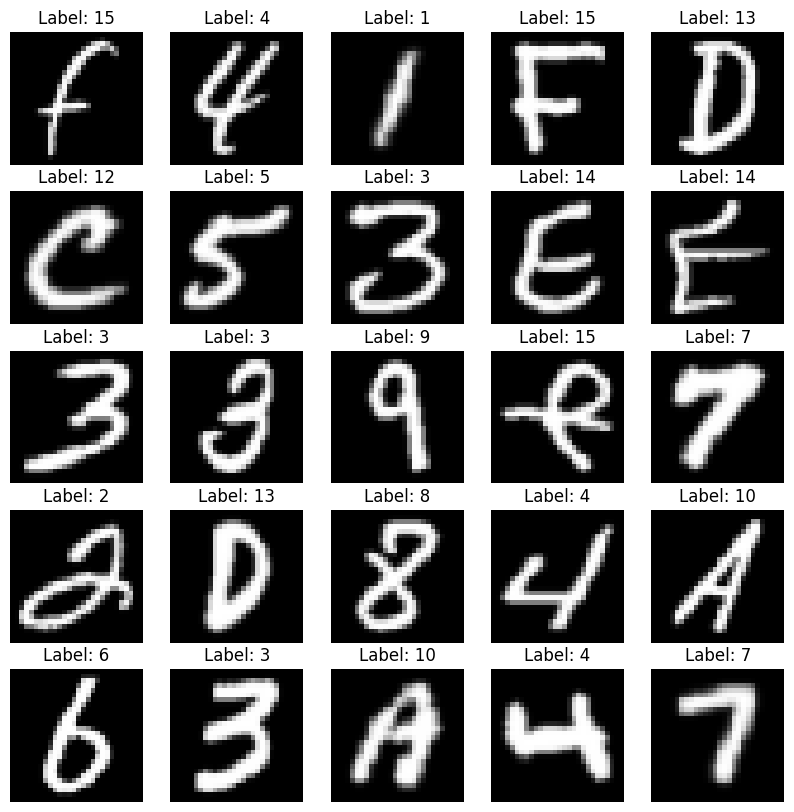

In [3]:
# Plotten Sie hier ein paar Ziffern!
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {Y_train[i]}")
    plt.axis('off')
plt.show()

In [4]:
# Normalisieren Sie das Set und bringen es in die richtige "shape"
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_test_norm = (X_test - np.mean(X_test)) / np.std(X_test)

X_train_norm_reshape = X_train_norm.reshape([*X_train_norm.shape, 1])
Y_train_reshape = tf.keras.utils.to_categorical(Y_train)
X_test_norm_reshape = X_test_norm.reshape([*X_test_norm.shape, 1])
Y_test_reshape = tf.keras.utils.to_categorical(Y_test)

print(np.shape(X_train_norm_reshape))
print(np.shape(Y_train_reshape))
print(np.shape(X_test_norm_reshape))
print(np.shape(Y_test_reshape))

(38400, 28, 28, 1)
(38400, 16)
(6400, 28, 28, 1)
(6400, 16)


In [5]:

# Laden des Modells
base_model = tf.keras.models.load_model("mnist_model.keras")

#Hier die letzte Schicht entfernen
base_model.pop()
base_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,470 (345.59 KB)

 Trainable params: 18,816 (73.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 69,654 (272.09 KB)

In [6]:

# Modell einfrieren
base_model.trainable = False

# Basismodell als Ausgangspunkt nehmen
inputs = tf.keras.Input(shape=(28, 28,1))
x = base_model(inputs, training=False)

# Hier einen Dense-layer und einmal Softmax hinzufügen, sodass die verschiedenen Klassen vorhergesagt werden können!
last_layer = tf.keras.layers.Dense(16)(x)
output = tf.keras.layers.Activation('softmax')(last_layer)

# Modell Zusammenfügen
model = tf.keras.Model(inputs, output)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1600)           │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        25,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,432 (173.56 KB)

 Trainable params: 25,616 (100.06 KB)

 Non-trainable params: 18,816 (73.50 KB)

In [7]:
# Modell Kompilieren, Kostenfunktion categorical_crossentropy, Optimizer Adam mit der learningrate 1e-4
res = model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1600)           │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        25,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,432 (173.56 KB)

 Trainable params: 25,616 (100.06 KB)

 Non-trainable params: 18,816 (73.50 KB)

In [8]:
# Accuracy vor dem Transferlearning bestimmen
loss0, accuracy0 = model.evaluate(X_test_norm_reshape, Y_test_reshape)
print("loss: ", loss0)
print("accuracy: ", accuracy0)

ValueError: Cannot get result() since the metric has not yet been built.

In [ ]:
# Hier das Netzwerk für 10 Epochen trainieren!
history = model.fit(X_train_norm_reshape, Y_train_reshape,
                  batch_size=128,
                  epochs=10,
                  validation_data=(X_test_norm_reshape, Y_test_reshape)
                 )

In [ ]:
# Plotten der Trainingskurve wie in der Aufgabe zuvor
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [ ]:
# Confusion Matrix erstellen
pred=model.predict(X_test_norm_reshape)
print(confusion_matrix(np.argmax(Y_test_reshape,axis=1),np.argmax(pred,axis=1)))